In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats

from copy import deepcopy

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import optuna
from optuna import Trial, visualization

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score, mean_squared_error

# Tabular Playground Series 📚 - Jan 2021 📈

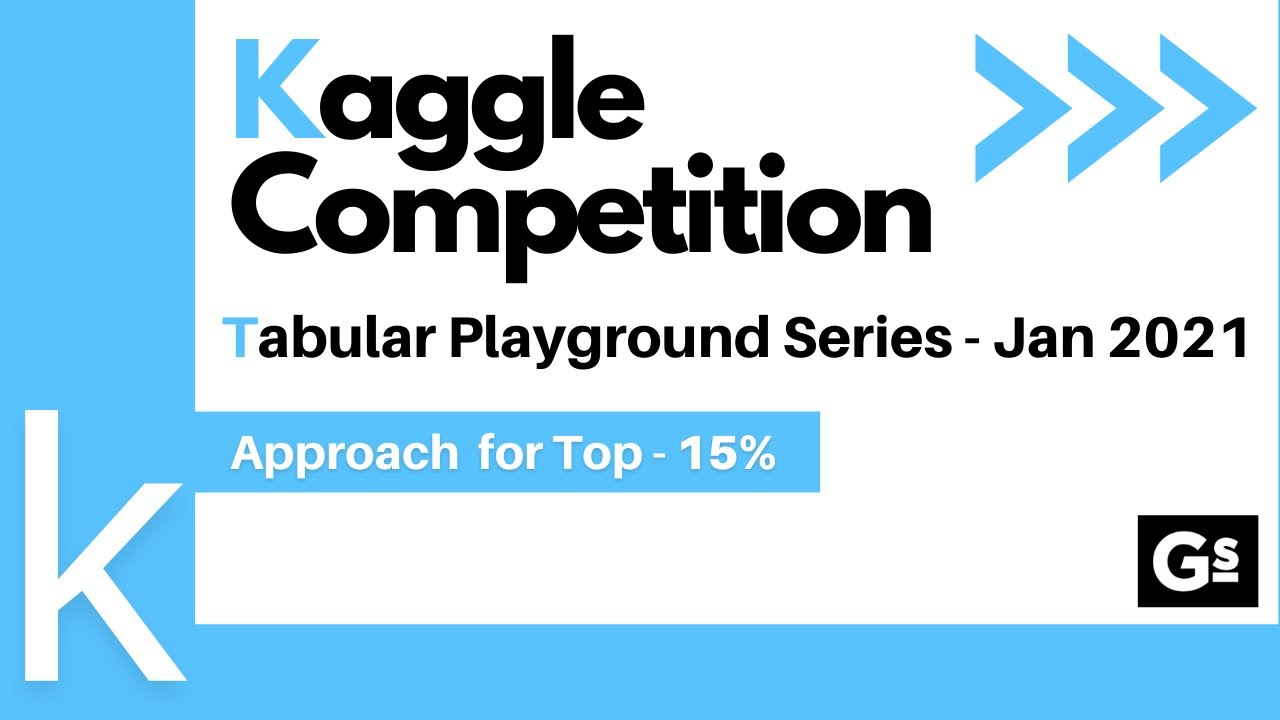

In [ ]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2021/test.csv')
sub_df = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2021/sample_submission.csv')

train_df.head()

In [ ]:
feature_cols = train_df.drop(['id', 'target'], axis=1).columns

x = train_df[feature_cols]
y = train_df['target']

print(x.shape, y.shape)

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_indexs = train_df.index
test_indexs = test_df.index

df =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)
df = df.drop('id', axis=1)

len(train_indexs), len(test_indexs)

# 1. Data Visualization 📊

In [ ]:
def fix_skew(features):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numerical_columns = features.select_dtypes(include=['int64','float64']).columns

    # Check the skew of all numerical features
    skewed_features = features[numerical_columns].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
    high_skew = skewed_features[abs(skewed_features) > 0.5]
    skewed_features = high_skew.index

    # Perform the Box-Cox transformation
    for column in skewed_features:
        features[column] = boxcox1p(features[column], boxcox_normmax(features[column] + 1))
        
    return features

In [ ]:
# I want to thanks @masumrumi for sharing this amazing plot!
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );

In [ ]:
df.info()

## Target distribution

In [ ]:
plotting_3_chart(df, 'target')

As we can see, the target is close to binomial without much skewness. We could latter try to adjust it to a Gaussian.

## Features distribution analysis

In [ ]:
num_rows, num_cols = 4,4

f, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
#f.suptitle('Distribution of Features', fontsize=16)

for index, column in enumerate(df[feature_cols].columns):
    i,j = (index // num_cols, index % num_cols)
    g = sns.distplot(train_df[column], color="m", label="%.2f"%(train_df[column].skew()), ax=axes[i,j])
    g = g.legend(loc="best")


plt.tight_layout()
plt.show()

## Correlation analysis

In [ ]:
corr = df[feature_cols].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(14, 14))

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

We can check that the variables are low correlated so we cna go ahead with the full set.

# 2. Feature Engineering ⚙️

I am not going to do any feature engineering since the variables seems to be very clean and clear and there are no missing values.

In the future we can try to:

* Try to transform target feature to better fit a normal distribution. 
* Sometime (not always) is useful to try a similar transformation for the model features as well; in their case, also scaling will improve the result with some of the models;

# 3. Simple model: XGBoost Regressor

In [ ]:
param_grid = {
    'n_estimators': [5, 10, 15, 20],
    'max_depth': [2, 5, 7, 9]
}

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Instantiate model with 100 decision trees
clf = XGBRegressor(random_state = 42)

clf.fit(x_train, y_train)

In [ ]:
# Use the forest's predict method on the test data
predictions = clf.predict(x_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


# 4. XGBoost Optuna Optimization

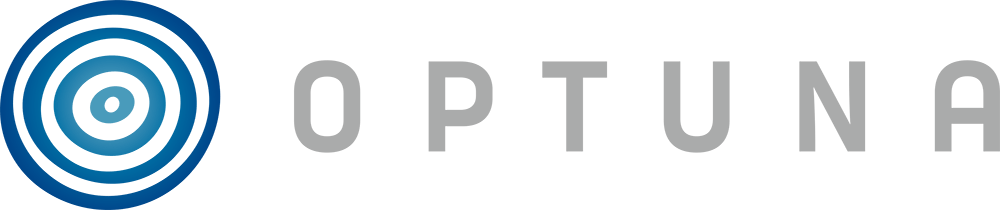

In [ ]:
def objective(trial,data=x,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        'tree_method':'gpu_hist',  # Use GPU acceleration
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300, 3000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    model = XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study.trials_dataframe().head()

### Visualization

Now, that we have the optimization done, we can take a look of the output of the algorithm.

In [ ]:
# plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# plot feature importance for algorithm parameters
visualization.plot_param_importances(study)

In [ ]:
# finally plot best parameters
study.best_params

In [ ]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

# 5. Train final model

Now we are going to train the final model with the best parameters

In [ ]:
best_params = study.best_params
best_params['tree_method'] = 'gpu_hist'
best_params['random_state'] = 42

clf = XGBRegressor(**(best_params))

clf.fit(x, y)

# 6. Submission

In [ ]:
preds = pd.Series(clf.predict(test_df.drop('id', axis=1)), name='target')
preds = pd.concat([test_df['id'], preds], axis=1)

In [ ]:
preds.head()

In [ ]:
preds.to_csv("submission.csv", index=False)